In [1]:
import pandas as pd

In [2]:
data_path = '../data/ISEAR.csv'

In [3]:
df = pd.read_csv(data_path, header=None)
df.head()

,0,1,2
0,0,joy,On days when I feel close to my partner and ot...
1,1,fear,Every time I imagine that someone I love or I ...
2,2,anger,When I had been obviously unjustly treated and...
3,3,sadness,When I think about the short time that we live...
4,4,disgust,At a gathering I found myself involuntarily si...


In [4]:
df = df.drop([0])
df.head()

,0,1,2
1,1,fear,Every time I imagine that someone I love or I ...
2,2,anger,When I had been obviously unjustly treated and...
3,3,sadness,When I think about the short time that we live...
4,4,disgust,At a gathering I found myself involuntarily si...
5,5,shame,When I realized that I was directing the feeli...


In [5]:
col_names = ['emotion', 'text']

In [6]:
df = df.rename(columns={1: "emotion", 2: "text"}, errors="raise")
df.head()

,0,emotion,text
1,1,fear,Every time I imagine that someone I love or I ...
2,2,anger,When I had been obviously unjustly treated and...
3,3,sadness,When I think about the short time that we live...
4,4,disgust,At a gathering I found myself involuntarily si...
5,5,shame,When I realized that I was directing the feeli...


In [7]:
df = df.drop([0], axis=1)

In [8]:
df.head()

,emotion,text
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...
5,shame,When I realized that I was directing the feeli...


In [9]:
# !pip install nltk

In [10]:
import string
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

review_lines = list()
lines = df['text'].values.tolist()


print("Starting...")
for line in lines:
    tokens = word_tokenize(line)

    # lower case
    tokens = [word.lower() for word in tokens]
    
    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in tokens]
    
    # take only alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    # filter stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    review_lines.append(words)

data = []
for sentences in review_lines:
    data.append(" ". join(sentences))

# cleaned_df = pd.DataFrame(data={'review': data, 'emotion': df['emotion'].values.tolist()})
# cleaned_df.to_csv('cleaned_movie_data.csv', index=False, encoding='utf-8')

Starting...


In [11]:
cleaned_df = pd.DataFrame(data={'review': data, 'emotion': df['emotion'].values.tolist()})
cleaned_df.head()

,review,emotion
0,every time imagine someone love could contact ...,fear
1,obviously unjustly treated possibility elucida...,anger
2,think short time live relate periods life thin...,sadness
3,gathering found involuntarily sitting next two...,disgust
4,realized directing feelings discontent partner...,shame


In [12]:
df = cleaned_df.copy()

In [13]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(df['emotion'])
y = encoder.transform(df['emotion'])

In [14]:
df['emotion'] = y

In [15]:
from sklearn.model_selection import train_test_split
train_review, test_review, train_emotion, test_emotion = train_test_split(df['review'],
                                                                              df['emotion'], 
                                                                              test_size=0.20,
                                                                              stratify=df['emotion'], 
                                                                              random_state=42
                                                                              )

In [16]:
train_review_lines = [line.split(" ") for line in train_review.values.tolist()]
test_review_lines = [line.split(" ") for line in test_review.values.tolist()]

y_train = train_emotion.values
y_test = test_emotion.values

In [17]:
y_train

array([3, 6, 3, ..., 0, 6, 2])

In [18]:
import math
mean = 0
word_counts = []
for line in train_review_lines:
    mean += len(line)
    word_counts.append(len(line))
mean = math.ceil(mean/len(train_review_lines))
print(f"Minimum number of words: {min(word_counts)}") 
print(f"Maximum number of words: {max(word_counts)}")
print(f"Mean number of words: {mean}")

Minimum number of words: 1
Maximum number of words: 79
Mean number of words: 10


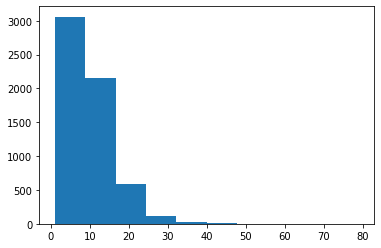

In [19]:
import matplotlib.pyplot as plt
plt.hist(word_counts)
plt.show()

In [20]:
df['review'].value_counts()

grandmother died                                                                      9
grandfather died                                                                      9
well examn                                                                            8
response                                                                              6
death grandmother                                                                     4
                                                                                     ..
phoned friend mine ask news marks exam told passed                                    1
dad passed away                                                                       1
people refuse house jobs give work someone else                                       1
close friend mine refused entrance medical school grades good left biased judgment    1
made boyfriend unhappy depressed feel guilty                                          1
Name: review, Length: 7338, dtyp

May not perform better in LSTM

In [21]:
MAX_SEQUENCE_LENGTH = 10

In [22]:
# !pip install tensorflow

In [23]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_review_lines) # fit on train set

# train sequences
train_sequences = tokenizer.texts_to_sequences(train_review_lines)

# test sequences
test_sequences = tokenizer.texts_to_sequences(test_review_lines)

# train pad sequences (length = MAX_SEQUENCE_LENGTH)
X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# test pad sequences (length = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [24]:
word_index = tokenizer.word_index
test_words = ['nice', 'good', 'bad', 'better']
for word in test_words:
  print(f"{word}: {word_index[word]}")

nice: 466
good: 39
bad: 94
better: 417


In [25]:
# pip install keras

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.layers.embeddings import Embedding
from keras.initializers import RandomNormal

NUM_TOKENS = len(word_index) + 1
EMBEDDING_DIM = 150

model_clf = Sequential(name='imbd_sentiment_classifier')
embedding_layer = Embedding(input_dim=NUM_TOKENS,
                            output_dim=EMBEDDING_DIM,
                            embeddings_initializer=RandomNormal(),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True
                            )
model_clf.add(embedding_layer)
model_clf.add(Flatten())
model_clf.add(Dense(7, activation='softmax'))
model_clf.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_clf.summary())

Model: "imbd_sentiment_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 150)           1190400   
_________________________________________________________________
flatten (Flatten)            (None, 1500)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 10507     
Total params: 1,200,907
Trainable params: 1,200,907
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
%%time
print("Training......")
model_clf.fit(X_train, y_train, batch_size=32, epochs=25, shuffle=True, validation_split=0.2, verbose=1)

Training......
Epoch 1/25
149/149 [==============================] - 3s 17ms/step - loss: 1.9071 - accuracy: 0.2357 - val_loss: 1.8523 - val_accuracy: 0.3414
Epoch 2/25
149/149 [==============================] - 2s 16ms/step - loss: 1.5658 - accuracy: 0.6749 - val_loss: 1.6030 - val_accuracy: 0.4513
Epoch 3/25
149/149 [==============================] - 2s 16ms/step - loss: 1.0205 - accuracy: 0.8168 - val_loss: 1.4084 - val_accuracy: 0.5000
Epoch 4/25
149/149 [==============================] - 2s 16ms/step - loss: 0.5792 - accuracy: 0.9053 - val_loss: 1.3565 - val_accuracy: 0.5017
Epoch 5/25
149/149 [==============================] - 2s 16ms/step - loss: 0.3321 - accuracy: 0.9540 - val_loss: 1.3581 - val_accuracy: 0.5034
Epoch 6/25
149/149 [==============================] - 2s 16ms/step - loss: 0.2051 - accuracy: 0.9757 - val_loss: 1.3790 - val_accuracy: 0.4983
Epoch 7/25
149/149 [==============================] - 2s 16ms/step - loss: 0.1360 - accuracy: 0.9845 - val_loss: 1.4130 - val_a